In [1]:
'ADC to FFT Withbaby new approach'


'ADC to FFT Withbaby new approach'

# Loading the Data

In [1]:
import gc
gc.collect()

126

In [2]:
%reset -f

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [6]:
# Set directory containing CSV files
data_dir = r"D:\AIS & ML\realtime testing\testbaby"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [7]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,-4,-7,-11,-19,-25,-28,-31,-29,-29,-33
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,9,7,0,-3,-9,-16,-21,-19,-22,-20
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,11,7,3,-2,-7,-8,-14,-18,-24,-32
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,0,5,13,16,15,23,28,31,31,30
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,-16,-19,-20,-24,-29,-27,-29,-32,-34,-31
5,64,32768,1,1,512,0,1953125,12,0.0,0,...,-23,-24,-19,-10,-4,4,6,10,10,15
6,64,32768,1,1,512,0,1953125,12,0.0,0,...,33,27,22,17,15,11,9,8,4,2
7,64,32768,1,1,512,0,1953125,12,0.0,0,...,32,27,27,24,18,15,6,4,4,-2
8,64,32768,1,1,512,0,1953125,12,0.0,0,...,33,34,34,35,38,38,37,32,29,24
9,64,32768,1,1,512,0,1953125,12,0.0,0,...,-23,-20,-19,-13,-9,-5,-2,4,6,11


In [8]:
combined_df.shape

(10, 16400)

In [9]:
adc_data = combined_df.iloc[:, 16:].values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[-36, -34, -32, ..., -29, -29, -33],
       [-20, -23, -27, ..., -19, -22, -20],
       [-34, -37, -36, ..., -18, -24, -32],
       ...,
       [ -4,  -7,  -8, ...,   4,   4,  -2],
       [ 17,  12,   7, ...,  32,  29,  24],
       [ 15,  21,  24, ...,   4,   6,  11]], shape=(10, 16384))

In [10]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[ -52.34028267,  -78.04274451, -102.59568817, ...,  -26.15876986,
         -28.52757154,  -30.59947143],
       [ -36.0855018 ,  -69.82258064, -102.59952748, ...,  -12.90753696,
         -15.27202941,  -17.34554578],
       [ -47.01042589,  -81.12087122, -114.63823616, ...,  -17.51177196,
         -20.55545906,  -23.27629633],
       ...,
       [  -8.24473158,  -36.35741412,  -64.54058859, ...,   10.46211641,
           8.33659827,    6.41035199],
       [  34.2879413 ,   45.74838676,   55.9048207 , ...,   32.14036457,
          31.740678  ,   31.31731052],
       [  15.86905924,   46.12292398,   76.70325272, ...,   -0.20366252,
           1.94468918,    3.87735989]], shape=(10, 16384))

In [11]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 22.67 dB


In [14]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([  4.8731446 , -11.57358475,   4.59314466,   6.95571968,
         4.55676893,   6.59725193,  11.70774264, -10.93815556,
        15.16121833,  -9.65302469])

# ADC to FFT Conversion

In [20]:
# Assuming `adc_data` is your pandas Series with ADC data
adc_array = adc_data_selected_columns # Convert the pandas Series to a numpy array

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Filter frequencies within 35kHz - 45kHz
#valid_indices = (freq >= min_freq) & (freq <= max_freq)
#filtered_freqs = freq[valid_indices]
#filtered_magnitudes = magnitude[valid_indices]
#filtered_phase = phase[valid_indices]

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})


fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.0,22.613350,0.000000
1,195312.5,18.273343,-2.805970
2,390625.0,7.095907,0.403994
3,585937.5,12.028819,1.936965
4,781250.0,11.062640,-1.737490


In [21]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
#For Withbaby vs Withoutbaby
fft_df['Infant_Presence'] = 1 # 1 for presence, 0 for absence 

# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.0,22.613350,0.000000,1
1,195312.5,18.273343,-2.805970,1
2,390625.0,7.095907,0.403994,1
3,585937.5,12.028819,1.936965,1
4,781250.0,11.062640,-1.737490,1


In [22]:
len(fft_df)

10

In [29]:
fft_df.tail()

,Frequency,FFT Magnitude,Phase,Infant_Presence
5,-976562.5,11.129599,0.000000,1
6,-781250.0,11.062640,1.737490,1
7,-585937.5,12.028819,-1.936965,1
8,-390625.0,7.095907,-0.403994,1
9,-195312.5,18.273343,2.805970,1


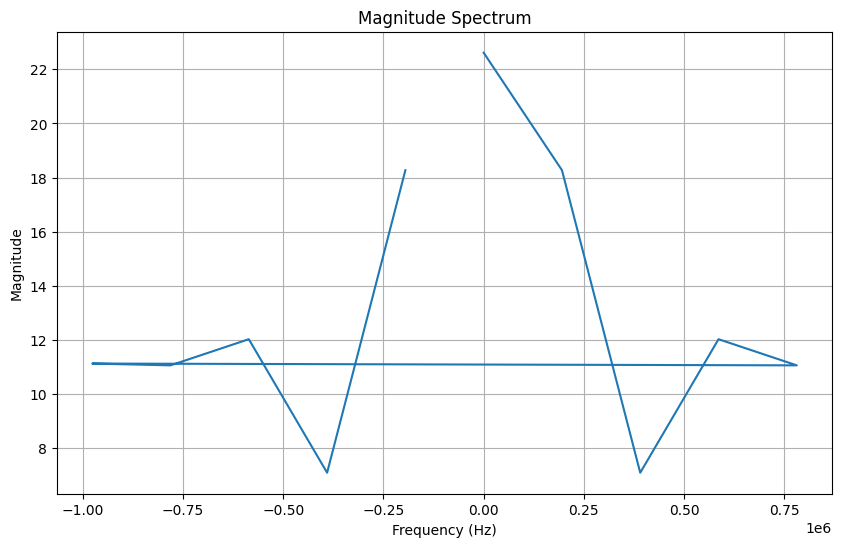

In [31]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

# Saving as Numpy Array

In [33]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
np.save('demo_4.npy', numpy_array)


In [55]:
import gc
gc.collect()

0

In [53]:
%reset -f